In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import time
import folium
import folium.plugins
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.float_format = lambda x: f'{x:.3f}'

print(f'folium: {folium.__version__}')
print(f'requests: {requests.__version__}')
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'matplotlib: {mpl.__version__}')

%matplotlib inline

folium: 0.15.1
requests: 2.31.0
pandas: 2.1.3
numpy: 1.26.2
seaborn: 0.13.0
matplotlib: 3.8.2


In [2]:
airbnb = pd.read_csv("NYC-Airbnb-2023.csv", low_memory=False)
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42931 entries, 0 to 42930
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42931 non-null  int64  
 1   name                            42919 non-null  object 
 2   host_id                         42931 non-null  int64  
 3   host_name                       42926 non-null  object 
 4   neighbourhood_group             42931 non-null  object 
 5   neighbourhood                   42931 non-null  object 
 6   latitude                        42931 non-null  float64
 7   longitude                       42931 non-null  float64
 8   room_type                       42931 non-null  object 
 9   price                           42931 non-null  int64  
 10  minimum_nights                  42931 non-null  int64  
 11  number_of_reviews               42931 non-null  int64  
 12  last_review                     

# 에어비앤비 컬럼 정리

|#|출력명|자료형|유형|결측|출력 설명|범위|비고|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1|host_id|정수형(int64)|명목형|F|airbnb 호스트 식별자 ID||고유값-삭제|
|2|host_name|문자형(object)|명목형|T|호스트 첫번째 이름(개인이름)|||
|3|borough|문자형(object)|명목형|F|뉴욕시의 자치구|"Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"|neighbourhood_group=>borough 변수명 변경|
|4|neighbourhood|문자형(object)|명목형|F|뉴욕시의 특정 동네, 지역|||
|5|latitude|실수형(float64)|연속형|F|위도||숙소 위치|
|6|longitude|실수형(float64)|연속형|F|경도||숙소 위치|
|7|room_type|문자형(object)|명목형|F|숙소 유형|"Entire home/apt", "Private room", "Hotel room", "Shared room"||
|8|price|정수형(int64)|연속형|F|숙소 가격||호스트가 지정한 숙소의 가격|
|9|minimum_nights|정수형(int64)|연속형|F|최소 숙박일 수|||
|10|number_of_reviews|정수형(int64)|연속형|F|숙소 리뷰 수|||
|11|last_review|문자형(object)|명목형|T|마지막 리뷰|||
|12|reviews_per_month|실수형(float64)|연속형|T|숙소 월별 평균 리뷰 수|||
|13|calculated_host_listings_count|정수형(int64)|연속형|F|호스트의 숙소 소유 개수|||
|14|availability_365|정수형(int64)|연속형|F|연간 이용 가능일|||
|15|number_of_reviews_ltm|정수형(int64)|연속형|F|최근 1년간 받은 리뷰 수|||
|*|id|정수형(int64)|명목형|F|airbnb 숙소 식별자 ID||고유값-삭제|
|*|name|문자형(object)|명목형|T|숙소 목록 이름||고유값-삭제|
|*|license|문자형(object)|명목형|T|라이센스||전체 데이터에 값이 1개-삭제|

# 전처리

## 변수명 변경

In [3]:
airbnb['borough'] = airbnb['neighbourhood_group']

## 변수삭제

### 결측 대부분인 변수

In [4]:
airbnb.drop(columns=['license'], axis=1, inplace=True)

### id등 고유식별자

In [5]:
airbnb.drop(columns=['id','name'], axis=1, inplace=True)

### 이름 변경된 변수 제거

In [6]:
airbnb.drop(columns=['neighbourhood_group'],axis=1, inplace=True)

In [7]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42931 entries, 0 to 42930
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         42931 non-null  int64  
 1   host_name                       42926 non-null  object 
 2   neighbourhood                   42931 non-null  object 
 3   latitude                        42931 non-null  float64
 4   longitude                       42931 non-null  float64
 5   room_type                       42931 non-null  object 
 6   price                           42931 non-null  int64  
 7   minimum_nights                  42931 non-null  int64  
 8   number_of_reviews               42931 non-null  int64  
 9   last_review                     32627 non-null  object 
 10  reviews_per_month               32627 non-null  float64
 11  calculated_host_listings_count  42931 non-null  int64  
 12  availability_365                

## 위도, 경도 데이터 형식 변경

In [8]:
from decimal import Decimal

airbnb['latitude'] = airbnb['latitude'].apply(lambda x: Decimal(str(x)))
airbnb['longitude'] = airbnb['longitude'].apply(lambda x: Decimal(str(x)))

In [9]:
airbnb.head(20)

,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,borough
0,2845,Jennifer,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.300,3,314,1,Manhattan
1,7356,Garon,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.300,2,365,0,Brooklyn
2,7490,MaryEllen,Upper West Side,40.8038,-73.96751,Private room,75,2,118,2017-07-21,0.720,1,0,0,Manhattan
3,8967,Shunichi,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.410,1,106,52,Manhattan
4,7378,Rebecca,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.030,1,181,1,Brooklyn
5,127608,Chris,Clinton Hill,40.68292,-73.96381,Private room,93,3,350,2023-02-27,2.250,1,145,48,Brooklyn
6,8526,Susan,Upper East Side,40.76076,-73.96156,Entire home/apt,295,4,45,2022-10-03,0.270,1,1,4,Manhattan
7,9744,Laurie,South Slope,40.66801,-73.98784,Private room,124,3,223,2023-02-13,1.320,3,164,17,Brooklyn
8,117287,Lara Nicole,Hell's Kitchen,40.7672,-73.98464,Private room,200,1,68,2021-10-01,0.440,4,310,0,Manhattan
9,15991,Allen & Irina,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,189,2023-02-04,1.130,1,207,5,Brooklyn


## 결측치 탐색

In [10]:
airbnb.isna().sum()

host_id                               0
host_name                             5
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10304
reviews_per_month                 10304
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
borough                               0
dtype: int64

### host_name 결측치 unknown으로 변경

In [11]:
airbnb.host_name.fillna('unknown',inplace=True)

In [12]:
airbnb[airbnb['host_name'] == 'unknown']

,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,borough
2860,23077718,unknown,Crown Heights,40.67605,-73.95997,Private room,50,30,0,NaN,NaN,1,0,0,Brooklyn
3128,24576978,unknown,Greenpoint,40.72119,-73.95279,Entire home/apt,195,30,1,2015-10-20,0.010,1,0,0,Brooklyn
4012,33134899,unknown,Bushwick,40.69977,-73.92912,Private room,37,30,1,2015-07-01,0.010,1,0,0,Brooklyn
4347,5162530,unknown,Williamsburg,40.71944,-73.95645,Entire home/apt,145,30,0,NaN,NaN,1,0,0,Brooklyn
4732,39608626,unknown,Harlem,40.82992,-73.94033,Private room,28,30,1,2015-08-01,0.010,1,0,0,Manhattan


### last_review, reviews_per_month 결측치 대체 방법

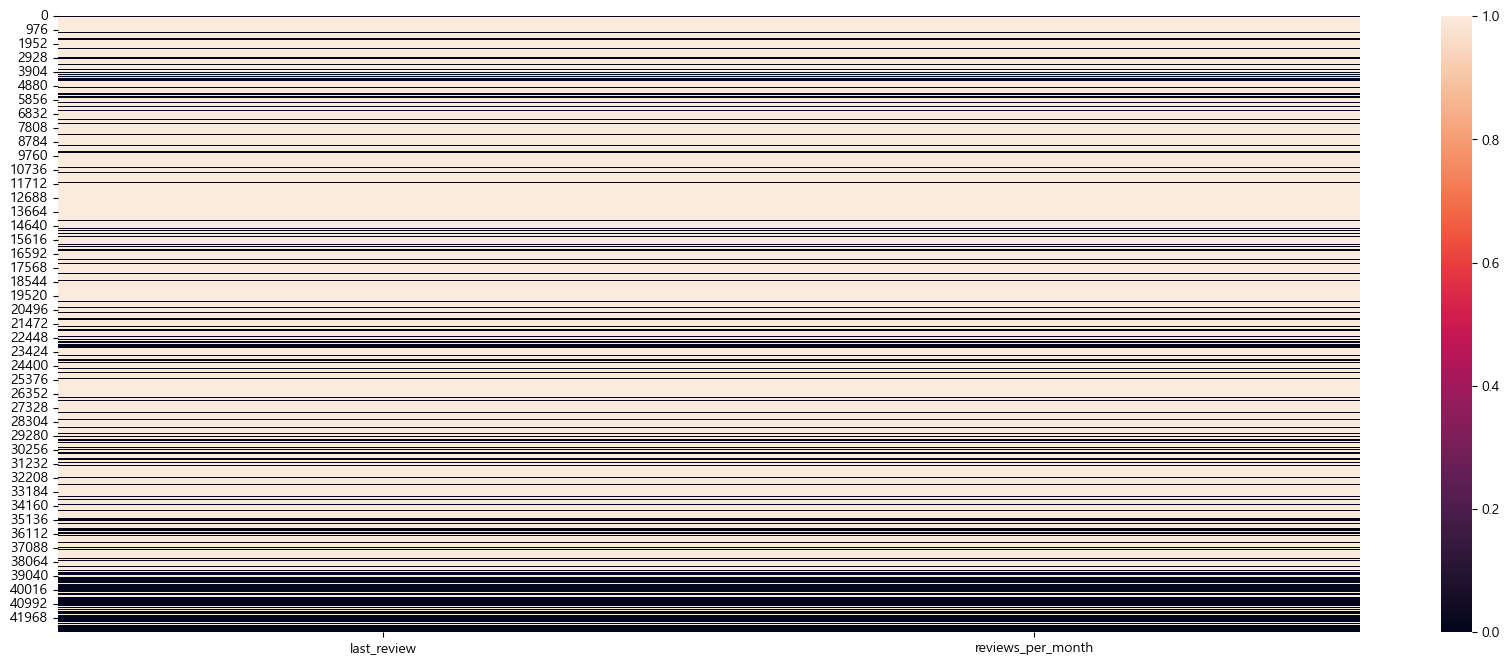

In [13]:
reviews = airbnb[['last_review', 'reviews_per_month']]

fig, ax = plt.subplots(figsize=(21, 8))
sns.heatmap(reviews[['last_review', 'reviews_per_month']].notna(), ax=ax)
plt.show()

두 변수의 결측치 패턴이 동일한 것으로 확인이 된다.

In [14]:
airbnb["last_review"].head(20)

0     2022-06-21
1     2019-12-02
2     2017-07-21
3     2023-02-19
4     2022-08-10
5     2023-02-27
6     2022-10-03
7     2023-02-13
8     2021-10-01
9     2023-02-04
10    2022-06-05
11    2022-12-14
12    2021-03-27
13    2022-06-26
14    2019-10-14
15           NaN
16    2023-01-01
17    2023-01-31
18    2022-11-02
19    2022-09-12
Name: last_review, dtype: object

날짜형 데이터를 가지고 있는 것을 확인 후, 다른 변수와의 연관성을 확인

In [15]:
miss_review = airbnb[airbnb['last_review'].isnull()]
miss_review['number_of_reviews_ltm'].value_counts()

number_of_reviews_ltm
0    10304
Name: count, dtype: int64

In [16]:
miss_review = airbnb[airbnb['last_review'].isnull()]
miss_review['availability_365'].value_counts()

availability_365
0      3769
365     861
364     497
90      144
339     111
       ... 
199       2
238       1
98        1
198       1
136       1
Name: count, Length: 366, dtype: int64

In [17]:
miss_review = airbnb[airbnb['last_review'].isnull()]
miss_review['number_of_reviews'].value_counts()

number_of_reviews
0    10304
Name: count, dtype: int64

리뷰 관련 변수의 값이 결측 변수 행에 대해서 모두 0임을 확인  
따라서, reviews_per_month : 숙소 월별 평균 리뷰 수 변수는 수치형 변수로 모두 0으로 대체한다.
        last_review : Not review의 값으로 대체한다.

### last_review,reviews_per_month 결측치 대체

In [18]:
airbnb.reviews_per_month.fillna(0, inplace=True)
airbnb.last_review.fillna("Not review", inplace=True)

In [19]:
airbnb.isna().sum()

host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
borough                           0
dtype: int64

## 이상치 탐색

In [20]:
airbnb.describe()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,42931.000,42931.000,42931.000,42931.000,42931.000,42931.000,42931.000,42931.000
mean,151601209.022,200.307,18.111,25.856,0.888,24.055,140.262,7.737
std,162130107.568,895.083,27.463,56.616,1.638,80.868,142.001,18.290
min,1678.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000
25%,16085328.000,75.000,2.000,1.000,0.010,1.000,0.000,0.000
50%,74338125.000,125.000,7.000,5.000,0.240,1.000,89.000,0.000
75%,268069240.500,200.000,30.000,24.000,1.170,4.000,289.000,7.000
max,503872891.000,99000.000,1250.000,1842.000,86.610,526.000,365.000,1093.000


### 숙소 가격

#### 숙소 가격이 0인 데이터 삭제
숙소 가격이  0달러 인 것은 가격 정보에 맞지않는 이상치이다.

In [21]:
(airbnb['price'] == 0).sum() # 가격이 0인 데이터 개수

27

In [22]:
airbnb = airbnb[airbnb['price'] != 0]
airbnb.describe()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,42904.000,42904.000,42904.000,42904.000,42904.000,42904.000,42904.000,42904.000
mean,151494340.899,200.433,18.117,25.829,0.888,24.069,140.350,7.732
std,162120782.644,895.350,27.468,56.527,1.637,80.891,142.003,18.286
min,1678.000,10.000,1.000,0.000,0.000,1.000,0.000,0.000
25%,16062665.500,75.000,2.000,1.000,0.010,1.000,0.000,0.000
50%,74321721.500,125.000,7.000,5.000,0.240,1.000,89.000,0.000
75%,267685057.000,200.000,30.000,24.000,1.170,4.000,289.000,7.000
max,503872891.000,99000.000,1250.000,1842.000,86.610,526.000,365.000,1093.000


#### 상자그림

<Axes: title={'center': 'price'}, xlabel='room_type'>

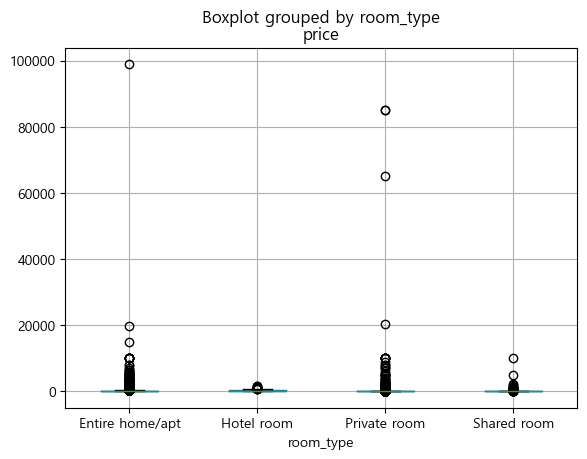

In [23]:
airbnb.boxplot(column='price', by='room_type')

In [24]:
room_price = airbnb.groupby('room_type')['price']
room_price.describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,24279.000,249.255,737.615,10.000,123.000,174.000,252.500,99000.000
Hotel room,170.000,359.188,275.585,99.000,204.750,254.500,372.250,1592.000
Private room,17879.000,135.015,1080.895,10.000,51.000,73.000,105.000,85170.000
Shared room,576.000,126.250,497.086,15.000,40.000,56.500,90.000,10000.000


#### 룸타입별 IQR, ufence, lfence 기준으로 가격 이상치 제한

In [25]:
for room_type, prices in room_price:
    Q1 = prices.quantile(0.25)
    Q3 = prices.quantile(0.75)
    IQR = Q3 - Q1
    ufence = Q3 + 1.5 * IQR
    lfence = Q1 - 1.5 * IQR

    print(f"Room Type: {room_type}",
    f"Q1: {Q1}",
    f"Q3: {Q3}",
    f"IQR: {IQR}",
    f"ufence: {ufence}",
    f"lfence: {lfence}\n")

Room Type: Entire home/apt Q1: 123.0 Q3: 252.5 IQR: 129.5 ufence: 446.75 lfence: -71.25

Room Type: Hotel room Q1: 204.75 Q3: 372.25 IQR: 167.5 ufence: 623.5 lfence: -46.5

Room Type: Private room Q1: 51.0 Q3: 105.0 IQR: 54.0 ufence: 186.0 lfence: -30.0

Room Type: Shared room Q1: 40.0 Q3: 90.0 IQR: 50.0 ufence: 165.0 lfence: -35.0



##### room_type별 이상치 제한 : Entire home/apt

In [26]:
room_class_ent = 'Entire home/apt'

room_prices_ent = airbnb.loc[airbnb['room_type'] == room_class_ent, 'price']
Q1 = np.percentile(room_prices_ent, 25)
Q3 = np.percentile(room_prices_ent, 75)
IQR = Q3 - Q1
ufence1 = Q3 + 1.5 * IQR
lfence1 = Q1 - 1.5 * IQR

outliers_ent = room_prices_ent[(room_prices_ent < lfence1) | (room_prices_ent > ufence1)]


print(f"ufence : {ufence1}, lfence : {lfence1}")
outliers_ent

ufence : 446.75, lfence : -71.25


23        596
35        900
54        750
117       650
164       500
         ... 
42873     800
42891     586
42892     650
42895     960
42901    1865
Name: price, Length: 1998, dtype: int64

In [27]:
#lfence 기준 이상치 제한
room_prices_ent_clipped = room_prices_ent.clip(upper=ufence1).astype('int64')
airbnb.loc[airbnb['room_type'] == room_class_ent, 'price'] = room_prices_ent_clipped

##### room_type별 이상치 제한 : Hotel room

In [28]:
room_class_hotel = 'Hotel room'

room_prices_hotel = airbnb.loc[airbnb['room_type'] == room_class_hotel, 'price']
Q12 = np.percentile(room_prices_hotel, 25)
Q32 = np.percentile(room_prices_hotel, 75)
IQR2 = Q32 - Q12
ufence2 = Q32 + 1.5 * IQR2
lfence2 = Q12 - 1.5 * IQR2

outliers_hotel = room_prices_hotel[(room_prices_hotel < lfence2) | (room_prices_hotel > ufence2)]


print(f"ufence : {ufence2}, lfence : {lfence2}")
outliers_hotel

ufence : 623.5, lfence : -46.5


5146     1245
15124    1000
15241    1000
15242    1000
15243    1000
15249    1000
15250    1000
15251    1000
15252    1000
15253    1000
15255    1000
17097    1164
17104     921
17167     692
17168    1092
17175    1592
17176    1492
17786     651
18996     625
18997     879
18998     938
Name: price, dtype: int64

In [29]:
#lfence 기준 이상치 제한
room_prices_hotel_clipped = room_prices_hotel.clip(upper=ufence2).astype('int64')
airbnb.loc[airbnb['room_type'] == room_class_hotel, 'price'] = room_prices_hotel_clipped

##### room_type별 이상치 제한 : Private room

In [30]:
room_class_priv = 'Private room'

room_prices_priv = airbnb.loc[airbnb['room_type'] == room_class_priv, 'price']
Q13 = np.percentile(room_prices_priv, 25)
Q33 = np.percentile(room_prices_priv, 75)
IQR3 = Q33 - Q13
ufence3 = Q33 + 1.5 * IQR3
lfence3 = Q13 - 1.5 * IQR3

outliers_priv = room_prices_priv[(room_prices_priv < lfence3) | (room_prices_priv > ufence3)]


print(f"ufence : {ufence3}, lfence : {lfence3}")
outliers_priv

ufence : 186.0, lfence : -30.0


8        200
24       205
78       349
83       349
97       200
        ... 
42820    291
42822    315
42823    329
42824    315
42911    200
Name: price, Length: 1811, dtype: int64

In [31]:
#lfence 기준 이상치 제한
room_prices_priv_clipped = room_prices_priv.clip(upper=ufence3).astype('int64')
airbnb.loc[airbnb['room_type'] == room_class_priv, 'price'] = room_prices_priv_clipped

##### room_type별 이상치 제한 : Shared room

In [32]:
room_class_share = 'Shared room'

room_prices_share = airbnb.loc[airbnb['room_type'] == room_class_share, 'price']
Q14 = np.percentile(room_prices_share, 25)
Q34 = np.percentile(room_prices_share, 75)
IQR4 = Q34 - Q14
ufence4 = Q34 + 1.5 * IQR4
lfence4 = Q14 - 1.5 * IQR4

outliers_share = room_prices_share[(room_prices_share < lfence4) | (room_prices_share > ufence4)]


print(f"ufence : {ufence4}, lfence : {lfence4}")
outliers_share

ufence : 165.0, lfence : -35.0


744       2000
868        350
1209       168
2129       207
2920       172
3155       199
3414       200
4445       800
4685      1350
5143       251
6758       200
6778       199
7104       360
8111       179
9851       175
9934       249
9971       320
11102      225
12801     1250
13611     2250
15756      299
16012      998
16104    10000
16306      500
16369      449
16723      429
17560      300
18284      208
18574     1000
18675     1560
19291      301
19724      200
21127      200
21534      250
22244      200
22835      180
22836      170
22837      170
23706      250
24684      200
24699      184
27208      650
27956      300
29246      175
31235      235
32014     1111
32571      225
32579      220
34041      975
36438      370
36634      247
36635      560
36638      480
38453      419
39037      399
39984     5000
40065      178
41242      175
Name: price, dtype: int64

In [33]:
#lfence 기준 이상치 제한
room_prices_share_clipped = room_prices_share.clip(upper=ufence4).astype('int64')
airbnb.loc[airbnb['room_type'] == room_class_share, 'price'] = room_prices_share_clipped

In [34]:
room_price = airbnb.groupby('room_type')['price']
room_price.describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,24279.000,203.936,107.983,10.000,123.000,174.000,252.500,446.000
Hotel room,170.000,310.906,150.619,99.000,204.750,254.500,372.250,623.000
Private room,17879.000,86.367,45.925,10.000,51.000,73.000,105.000,186.000
Shared room,576.000,71.908,43.980,15.000,40.000,56.500,90.000,165.000


#### 제한 후 상자그림

<Axes: title={'center': 'price'}, xlabel='room_type'>

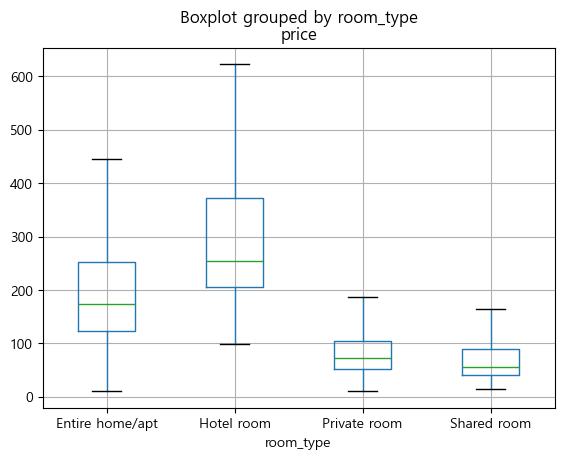

In [35]:
airbnb.boxplot(column='price', by='room_type')

private room(개인실, 공유공간)과 shared room(다른 게스트와 공유하는 방)의 가격이 상대적으로 저렴한 분포를 가지고 있으며,
Entire home/apt(독채),Hotel room(호텔)의 가격이 상대적으로 더 높은 가을 가지고 있고, 특히 Hotel room의 분포가 넓고 가장 가격이 높은 방의 유형이라고 볼 수 있습니다.

# EDA

## Q1. 하나의 호스트가 숙소 여러개를 상품으로 냈을 때 같은 유형의 숙소를 제공할까?

In [38]:
airbnb[["host_name", "host_id"]].groupby("host_id").value_counts()

host_id    host_name
1678       Adam         1
2234       Mary         1
2438       Tasos        1
2571       Teedo        1
2782       Matthew      1
                       ..
503593397  Brandon      1
503718879  Mehdi        1
503726515  Lashawn      1
503757175  Jazmin       1
503872891  Catherine    1
Name: count, Length: 27430, dtype: int64